In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from astroLuSt.synthetics import random as alr
from astroLuSt.preprocessing import dataseries_manipulation as aldm
from astroLuSt.preprocessing import sorting as als
from astroLuSt.preprocessing import hps
from astroLuSt.visualization import plots as alp
from astroLuSt.monitoring import timers as alt



#import model code
from astroLuSt.ai.models import periodlstm

import importlib

# Generate Training Data

## Homogeneous Data

In [2]:

importlib.reload(alr)
importlib.reload(aldm)

nsamples = 10000
periods = np.random.uniform(0.1, 100, (nsamples,1))
npoints = 30
x_offsets = np.random.randint(0, 100, nsamples)

GPS = alr.GeneratePeriodicSignals(
    periods=periods,
    npoints=npoints,
    x_offsets=x_offsets,
)
# print(GPS)

x_gen, y_gen = GPS.rvs(
    shape=None,
    # shape=(5,20),
    choices=None,
    x=None,
    noise_level_x=0.3,
    noise_level_y=0.4,
    func_kwargs=None
)

# fig, axs = GPS.plot_result()
# plt.show()

# # for idx in range(3):
# for idx in range(x_gen.shape[0]):
#     ph, pe = aldm.fold(x_gen[idx], periods[idx])
#     sortidx = np.argsort(ph)
#     plt.plot(ph[sortidx], y_gen[idx][sortidx], 'o-')

X = []
for xi, yi in zip(x_gen, y_gen):
    # print(xi.shape, yi.shape)
    xy = np.append(xi.reshape(-1,1), yi.reshape(-1,1), axis=1)
    X.append(xy)
X = np.array(X, dtype=np.float32)


np.save('./data/X_aiperiod_homogeneous.npy', X)
np.save('./data/y_aiperiod_homogeneous.npy', periods)


## Heterogeneous Data

In [3]:
importlib.reload(alr)
importlib.reload(aldm)

nsamples = 5000
periods = np.random.uniform(0.1, 100, (nsamples,1))
npoints = np.random.randint(20, 60, nsamples)
x_offsets = np.random.randint(0, 100, (nsamples,1))

GPS = alr.GeneratePeriodicSignals(
    periods=periods,
    npoints=npoints,
    x_offsets=x_offsets,
)
# print(GPS)

x_gen, y_gen = GPS.rvs(
    shape=None,
    # shape=(5,20),
    choices=None,
    x=None,
    noise_level_x=1,
    noise_level_y=0.7,
    func_kwargs=None
)

# fig, axs = GPS.plot_result()
# plt.show()

# # for idx in range(3):
# for idx in range(x_gen.shape[0]):
#     ph, pe = aldm.fold(x_gen[idx], periods[idx])
#     sortidx = np.argsort(ph)
#     plt.plot(ph[sortidx], y_gen[idx][sortidx], 'o-')

X = []
for xi, yi in zip(x_gen, y_gen):
    # print(xi.shape, yi.shape)
    xy = np.append(xi.reshape(-1,1), yi.reshape(-1,1), axis=1)
    X.append(xy)
X = np.array(X, dtype=object)

np.save('./data/X_aiperiod_heterogeneous.npy', X)
np.save('./data/y_aiperiod_heterogeneous.npy', periods)


# Train LSTM

- https://stackoverflow.com/questions/50748986/training-lstms-in-keras-with-time-series-of-different-length

## Load Data

In [2]:
importlib.reload(als)

X_het = np.load('./data/X_aiperiod_heterogeneous.npy', allow_pickle=True)   #heterogeneous dataset
y_het = np.load('./data/y_aiperiod_heterogeneous.npy', allow_pickle=True)   #heterogeneous dataset
X = np.load('./data/X_aiperiod_homogeneous.npy', allow_pickle=True).astype(np.float32)
y = np.load('./data/y_aiperiod_homogeneous.npy', allow_pickle=True).astype(np.float32)

print(f'Loaded Shape:')
print(f'    X:     {X.shape}, y: {y.shape}')
print(f'    X_het: {X_het.shape}, y_het: {y_het.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print('Train-Test-Split:')
print(f'    X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'    X_test:  {X_test.shape},  y_test:  {y_test.shape}')



Loaded Shape:
    X:     (10000, 30, 2), y: (10000, 1)
    X_het: (5000,), y_het: (5000, 1)
Train-Test-Split:
    X_train: (8000, 30, 2), y_train: (8000, 1)
    X_test:  (2000, 30, 2),  y_test:  (2000, 1)


### Organize such that same lengths are in same batches


In [3]:
# X_train, y_train = als.sort_into_batches(X_train, y_train)
# X_test,  y_test  = als.sort_into_batches(X_test,  y_test)
# X_het,   y_het   = als.sort_into_batches(X_het,   y_het)

print('Sorted into batches:')
print(f'    X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'    X_test:  {X_test.shape}, y_test:  {y_test.shape}')
print(f'    X_het:   {X_het.shape}, y_het:  {y_het.shape}')


Sorted into batches:
    X_train: (8000, 30, 2), y_train: (8000, 1)
    X_test:  (2000, 30, 2), y_test:  (2000, 1)
    X_het:   (5000,), y_het:  (5000, 1)


## Train

In [4]:
callbacks = (
    EarlyStopping(
        monitor='val_loss', min_delta=0,
        patience=5,
        restore_best_weights=True,
        start_from_epoch=0,
    ),
)

In [5]:
importlib.reload(periodlstm)


X_train_use, y_train_use = X_train, y_train 

model = periodlstm.PeriodLSTM((None,2), [16, 8], [64, 32, 16], 1)
model.build_model()
model.compile_model()
model.model.summary()
history = model.model.fit(X_train_use, y_train_use, epochs=100, batch_size=256, validation_split=0.2, callbacks=callbacks)
# history = model.model.fit(X_train_use, y_train_use, epochs=20, batch_size=1, callbacks=callbacks)
df_hist = pl.DataFrame(history.history)

Model: "period_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          1216      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 

shape: (100, 4)
┌─────────────┬──────────┬─────────────┬──────────────┐
│ loss        ┆ accuracy ┆ val_loss    ┆ val_accuracy │
│ ---         ┆ ---      ┆ ---         ┆ ---          │
│ f64         ┆ f64      ┆ f64         ┆ f64          │
╞═════════════╪══════════╪═════════════╪══════════════╡
│ 3325.205566 ┆ 0.0      ┆ 3246.902588 ┆ 0.0          │
│ 3266.50708  ┆ 0.0      ┆ 3106.469727 ┆ 0.0          │
│ 2952.828125 ┆ 0.0      ┆ 2567.911133 ┆ 0.0          │
│ 2130.175537 ┆ 0.0      ┆ 1487.040771 ┆ 0.0          │
│ ...         ┆ ...      ┆ ...         ┆ ...          │
│ 1.446446    ┆ 0.0      ┆ 1.484151    ┆ 0.0          │
│ 1.432267    ┆ 0.0      ┆ 1.497922    ┆ 0.0          │
│ 1.443728    ┆ 0.0      ┆ 1.472609    ┆ 0.0          │
│ 1.465084    ┆ 0.0      ┆ 1.607687    ┆ 0.0          │
└─────────────┴──────────┴─────────────┴──────────────┘


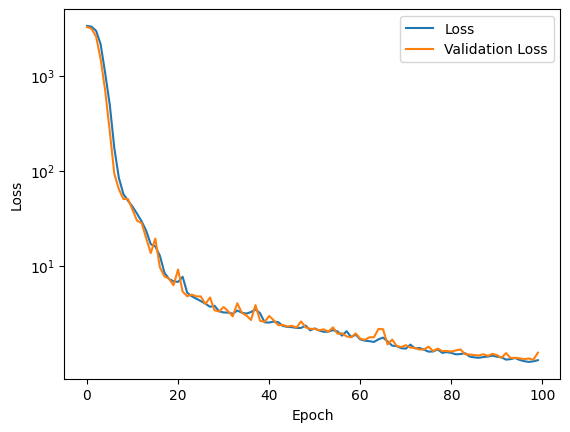

In [6]:
print(df_hist)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(df_hist.select(pl.col('loss')),     label='Loss')
ax1.plot(df_hist.select(pl.col('val_loss')), label='Validation Loss')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax1.set_yscale('symlog')

ax1.legend()

plt.show()

## Evaluate

In [7]:
X_test_use = X_test
y_test_use = y_test

# Make predictions
y_pred = model.model.predict(X_test_use)

63/63 [==============================] - 1s 4ms/step


63/63 [==============================] - 0s 5ms/step - loss: 1.5389 - accuracy: 0.0000e+00


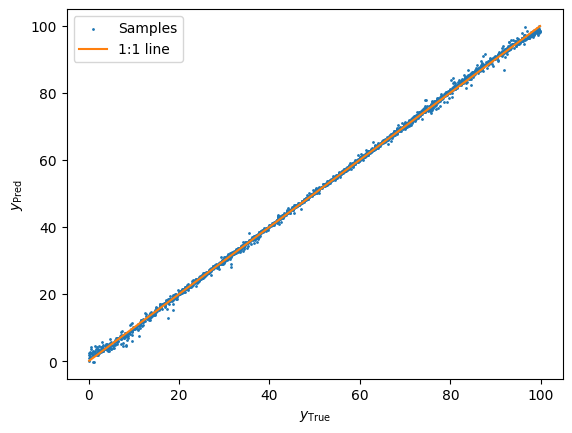

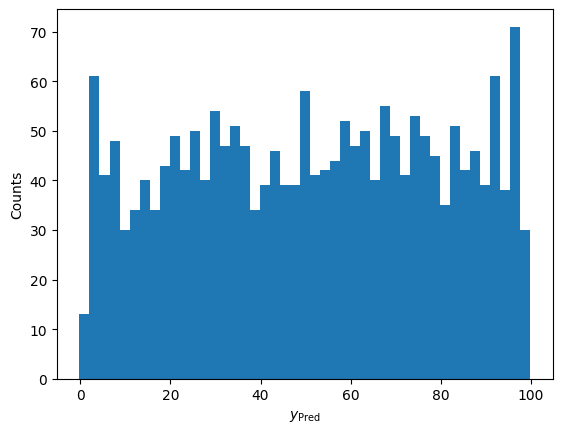

In [8]:
importlib.reload(alp)

model.model.evaluate(X_test_use, y_test_use)
# print(mean_squared_error(y_test, y_pred))

fig, axs = alp.plot_predictioneval(y_test_use[:,0], y_pred[:,0])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(y_pred, bins='sqrt')

ax1.set_xlabel(r'$y_\mathrm{Pred}$')
ax1.set_ylabel(r'Counts')
plt.show()

(30, 2) (8000, 1)


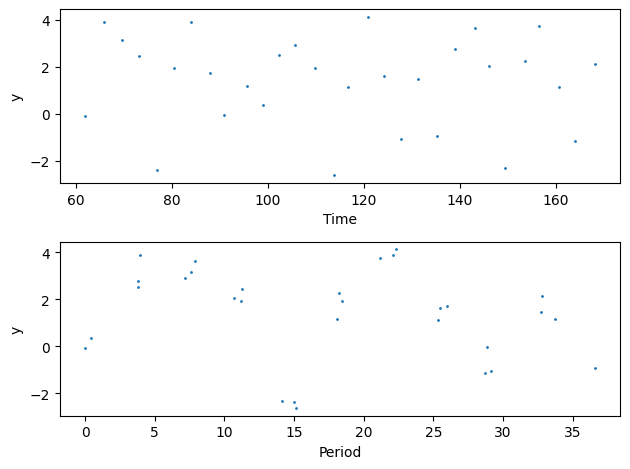

In [9]:
#Example curve
X_example = X_train[0,:]
y_example = y_train[:]
X_example = X_example.astype(np.float64)


print(X_example.shape, y_example.shape)
ph, pe = aldm.fold(X_example[:,0], y_example[0])

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.scatter(X_example[:,0], X_example[:,1], s=1)
ax2.scatter(pe,             X_example[:,1], s=1)

ax1.set_xlabel('Time')
ax2.set_xlabel('Period')
ax1.set_ylabel('y')
ax2.set_ylabel('y')
plt.tight_layout()
plt.show()


######################################################################
INFO: Started HPS (PDM + LS) for 5000 testperiods at 1686662375.7520196

INFO: Finished HPS (PDM + LS) for 5000 testperiods at 1686662383.0953407
Required time: 0 days 00:00:08
######################################################################

######################################################################
INFO: Started LSTM at 1686662383.1050038
1/1 [==============================] - 0s 28ms/step

INFO: Finished LSTM at 1686662383.190111
Required time: 0 days 00:00:00
######################################################################


,Task,Start,End,Duration,Start_Seconds,End_Seconds,Duration_Seconds,Comment_Start,Comment_End
0,HPS (PDM + LS) for 5000 testperiods,2023-06-13 13:19:35,2023-06-13 13:19:43,0 days 00:00:08,1.686662e+09,1.686662e+09,7.343321,,
1,LSTM,2023-06-13 13:19:43,2023-06-13 13:19:43,0 days 00:00:00,1.686662e+09,1.686662e+09,0.085107,,


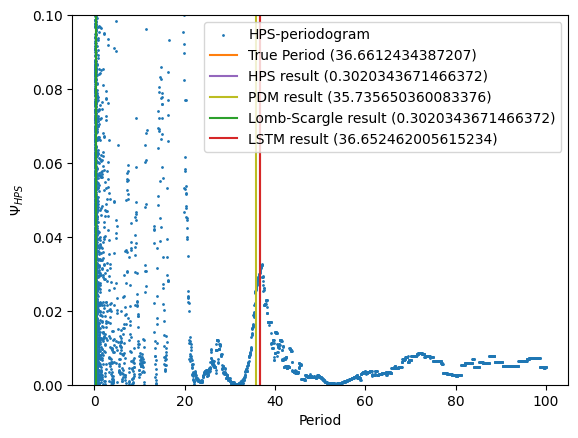

In [10]:
importlib.reload(hps)

ET = alt.ExecTimer()

nperiods = 5000
est = hps.HPS(
    period_start=np.nanmin(y_example), period_stop=np.nanmax(y_example),
    nperiods=nperiods,
    pdm_kwargs={'binning_kwargs':{'nintervals':0.5}},
    verbose=2,
    )

# print(est.period_start, est.period_stop)

ET.checkpoint_start(f'HPS (PDM + LS) for {nperiods} testperiods')
best_period_hps, best_psi = est.fit_predict(X_example[:,0].flatten(), X_example[:,1].flatten())
ET.checkpoint_end(f'HPS (PDM + LS) for {nperiods} testperiods')
best_period_ls  = 1/est.best_frequency_ls
best_period_pdm = est.best_period_pdm
ET.checkpoint_start('LSTM')
best_period_nn = model.model.predict(X_example.reshape(-1,*X_example.shape))
ET.checkpoint_end('LSTM')

display(ET.df_protocoll)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(est.trial_periods, est.psis_hps, color='tab:blue',   s=1, label='HPS-periodogram')
ax1.axvline(y_example[0],                    color='tab:orange',      label=f'True Period ({y_example[0,0]})')
ax1.axvline(best_period_hps,                 color='tab:purple',      label=f'HPS result ({best_period_hps})')
ax1.axvline(best_period_pdm,                 color='tab:olive',       label=f'PDM result ({best_period_pdm})')
ax1.axvline(best_period_ls,                  color='tab:green',       label=f'Lomb-Scargle result ({best_period_ls})')
ax1.axvline(best_period_nn[0,0],             color='tab:red',         label=f'LSTM result ({best_period_nn[0,0]})')
# 
ax1.legend()
ax1.set_ylim(0,0.1)

ax1.set_ylabel(r'$\Psi_{HPS}$')
ax1.set_xlabel('Period')

plt.show()

### Test on inhomogeneous data

When training a Long Short-Term Memory (LSTM) with sequences of equal length and attempting to predict a series with a different length, several challenges may arise. Let's explore the potential effects:

1. Sequence Mismatch: LSTMs are designed to learn patterns in sequences of fixed lengths. If you train an LSTM with sequences of equal length and then attempt to predict a series with a different length, there will be a sequence mismatch. The LSTM may struggle to generalize well to sequences of varying lengths, as it has not learned to handle such variations during training.

2. Limited Generalization: LSTMs trained on fixed-length sequences may have limited generalization capabilities when it comes to handling sequences with different lengths. The LSTM might not effectively capture the dependencies and patterns present in sequences of varying lengths, leading to suboptimal predictions.

3. Missing Context: If the LSTM is trained on equal-length sequences and then applied to predict a series with a different length, it may lack the necessary context to make accurate predictions. The LSTM's internal memory, which is designed to retain information over time, may not align properly with the varying lengths in the prediction task, resulting in difficulties capturing long-term dependencies.

4. Truncation or Padding: To make the sequences compatible during training, you may need to truncate or pad the sequences to a fixed length. Truncation may result in loss of valuable information if important patterns exist at the ends of the longer sequences. Padding may introduce additional noise and irrelevant information, which can affect the LSTM's ability to learn meaningful patterns.

5. Post-processing and Resampling: After training an LSTM on sequences of equal length and attempting to predict a series with different lengths, post-processing techniques might be required. Resampling or adjusting the predicted series to align with the desired length can be necessary, but it introduces an extra layer of complexity and potential errors.

To address these challenges, you can consider alternative approaches:

- Use a sequence-to-sequence model: Instead of training an LSTM to directly predict a variable-length series, you can train a sequence-to-sequence model using an encoder-decoder architecture, such as an LSTM-based encoder-decoder or Transformer model. This type of model is better suited for handling sequences of different lengths.

- Apply attention mechanisms: Attention mechanisms can help the model focus on relevant parts of the input sequence and provide more flexibility in handling sequences of varying lengths. Attention mechanisms allow the model to assign different weights to different parts of the input sequence, depending on their importance for prediction.

- Explore variable-length models: Some architectures, like the Transformer-XL or the Universal Transformer, are specifically designed to handle sequences of variable lengths more effectively. These models have mechanisms to retain context across different segment lengths and can potentially provide more accurate predictions.

- In summary, training an LSTM with sequences of equal length and predicting a series with a different length can present challenges due to sequence mismatches, limited generalization, and missing context. Exploring alternative models or architectures that handle variable-length sequences can help mitigate these issues and improve predictions.

In [11]:

ET.checkpoint_start('Prediction on X_het')
y_pred = np.array([])
y_true = np.array([])

X_het_b, y_het_b = als.sort_into_batches(X_het, y_het)
X_het_p = pad_sequences(sequences=X_het, maxlen=X_train.shape[1], padding='post', truncating='post', value=0.0)
print(X_het.shape)
print(X_het_p.shape)

for xb, yb in zip(X_het_b[:], y_het_b):
    
    xb = np.stack(xb)
    y_pred = np.append(y_pred, model.model.predict(xb).flatten())
    y_true = np.append(y_true, yb)


ET.checkpoint_end('Prediction on X_het')

y_pred_p = model.model.predict(X_het_p)

display(ET.df_protocoll)
    


######################################################################
INFO: Started Prediction on X_het at 1686662435.391305
(5000,)
(5000, 30, 2)
5/5 [==============================] - 0s 7ms/step

INFO: Finished Prediction on X_het at 1686662440.1171412
Required time: 0 days 00:00:05
######################################################################
157/157 [==============================] - 1s 5ms/step


,Task,Start,End,Duration,Start_Seconds,End_Seconds,Duration_Seconds,Comment_Start,Comment_End
0,HPS (PDM + LS) for 5000 testperiods,2023-06-13 13:19:35,2023-06-13 13:19:43,0 days 00:00:08,1.686662e+09,1.686662e+09,7.343321,,
1,LSTM,2023-06-13 13:19:43,2023-06-13 13:19:43,0 days 00:00:00,1.686662e+09,1.686662e+09,0.085107,,
2,Prediction on X_het,2023-06-13 13:20:35,2023-06-13 13:20:40,0 days 00:00:05,1.686662e+09,1.686662e+09,4.725836,,


343.18126772401956


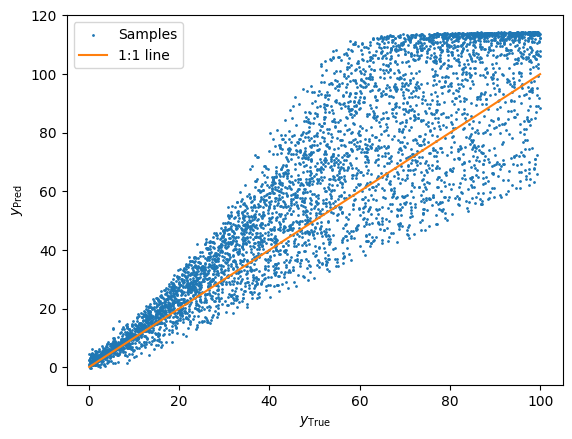

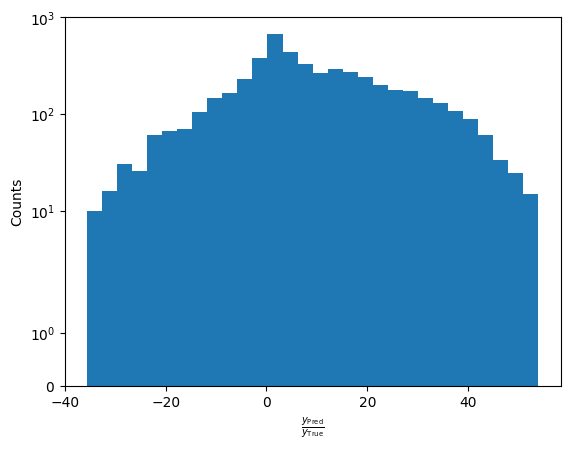

In [12]:
print(mean_squared_error(y_true, y_pred))
# print(mean_squared_error(y_true, y_pred_p))
fig, axs = alp.plot_predictioneval(y_true, y_pred)
# axs[0].scatter(y_true, y_pred_p, s=1, color='r')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(y_pred-y_true, bins=30)
ax1.set_xlabel(r'$\frac{y_\mathrm{Pred}}{y_\mathrm{True}}$')
ax1.set_ylabel(r'Counts')

ax1.set_yscale('symlog')

plt.show()

### Test on a RR Lyr LC

In [13]:
df_lc = pl.read_csv('../demos/data/tic1205396280.csv', sep=';')

X_lc = df_lc.select(pl.col(['time','norm_flux'])).to_numpy()
print(X_lc)

p_lstm = model.model.predict(X_lc.reshape(-1,*X_lc.shape))
p_hps, _ = est.fit_predict(X_lc[:,0], X_lc[:,1])

print(p_hps, p_lstm)


[[1.62497250e+03 9.48190251e-01]
 [1.62499333e+03 9.40775332e-01]
 [1.62501417e+03 9.26564026e-01]
 ...
 [1.65282683e+03 1.00455930e+00]
 [1.65284766e+03 1.00558494e+00]
 [1.65286849e+03 9.92438954e-01]]
1/1 [==============================] - 0s 112ms/step


KeyboardInterrupt: 

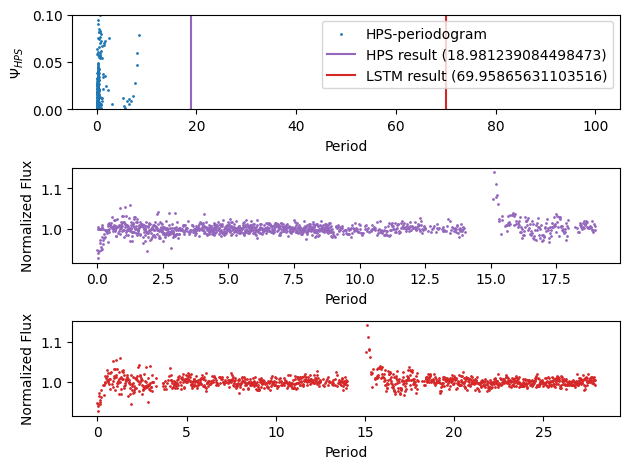

In [41]:

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.scatter(est.trial_periods, est.psis_hps, color='tab:blue',   s=1, label='HPS-periodogram')
# ax1.axvline(y_example[0],                    color='tab:orange',      label=f'True Period ({y_example[0,0]})')
ax1.axvline(p_hps,                 color='tab:purple',      label=f'HPS result ({p_hps})')
ax1.axvline(p_lstm[0,0],           color='tab:red',         label=f'LSTM result ({p_lstm[0,0]})')

ax2.scatter(aldm.fold(X_lc[:,0], p_hps)[1],  X_lc[:,1], s=1, color='tab:purple')
ax3.scatter(aldm.fold(X_lc[:,0], p_lstm)[1], X_lc[:,1], s=1, color='tab:red')

ax1.legend()
ax1.set_ylim(0,0.1)

ax1.set_ylabel(r'$\Psi_{HPS}$')
ax1.set_xlabel('Period')
ax2.set_xlabel('Period')
ax3.set_xlabel('Period')
ax2.set_ylabel('Normalized Flux')
ax3.set_ylabel('Normalized Flux')

plt.tight_layout()

plt.show()

'TEST'